# Install dependencies

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import gc  # For garbage collection


# Load the NetCDF file

In [4]:
nc_file = 'rr_ens_mean_0.1deg_reg_2011-2021_v25.0e.nc'
nc_data = Dataset(nc_file, mode='r')

# Inspect the dataset

In [5]:
for var in nc_data.variables:
    print(f"- {var}: {nc_data.variables[var].long_name if hasattr(nc_data.variables[var], 'long_name') else 'No long name'}")


- longitude: Longitude values
- latitude: Latitude values
- time: Time in days
- rr: rainfall


# Extract coordinate variables and check dimensions

In [9]:
# Extract coordinates and time first (these are much smaller)
longitude = nc_data.variables['longitude'][:]
latitude = nc_data.variables['latitude'][:]
time = nc_data.variables['time'][:]

# Check dimensions without loading rainfall data
rainfall_shape = nc_data.variables['rr'].shape

print(f"Rainfall data shape: {rainfall_shape}")
print(f"Time data length: {len(time)}")
print(f"Longitude data length: {len(longitude)}")
print(f"Latitude data length: {len(latitude)}")

Rainfall data shape: (4018, 465, 705)
Time data length: 4018
Longitude data length: 705
Latitude data length: 465


# Process data in memory-efficient chunks

In [10]:
# Create features based on geographic and temporal information
data_list = []

# Sample parameters
sample_times = min(len(time), 50)  # Sample times
time_chunk_size = 5  # Process this many time steps at once
sample_lats = min(len(latitude), 20)
sample_lons = min(len(longitude), 20)

# Calculate stride for spatial sampling
lat_stride = max(1, len(latitude)//sample_lats)
lon_stride = max(1, len(longitude)//sample_lons)

print(f"Using time chunks of size {time_chunk_size}")
print(f"Using latitude stride of {lat_stride}")
print(f"Using longitude stride of {lon_stride}")

# Process data in smaller time chunks to reduce memory usage
for t_start in range(0, sample_times, time_chunk_size):
    t_end = min(t_start + time_chunk_size, sample_times)
    
    print(f"Processing time chunk {t_start+1}-{t_end} out of {sample_times}")
    
    # Load only a small chunk of rainfall data with spatial strides
    rainfall_chunk = nc_data.variables['rr'][t_start:t_end, ::lat_stride, ::lon_stride]
    
    # Process this chunk
    for t_idx in range(rainfall_chunk.shape[0]):
        actual_t_idx = t_start + t_idx
        
        for lat_idx in range(rainfall_chunk.shape[1]):
            actual_lat_idx = lat_idx * lat_stride
            
            for lon_idx in range(rainfall_chunk.shape[2]):
                actual_lon_idx = lon_idx * lon_stride
                
                # Get values
                rain_value = rainfall_chunk[t_idx, lat_idx, lon_idx]
                
                # Skip if rainfall is a missing value
                if np.ma.is_masked(rain_value):
                    continue
                    
                # Create features using native Python types to save memory
                data_list.append({
                    'rainfall': float(rain_value),
                    'latitude': float(latitude[actual_lat_idx]),
                    'longitude': float(longitude[actual_lon_idx]),
                    'time_index': float(time[actual_t_idx]),
                    'rain_occurred': 1 if rain_value > 0 else 0
                })
    
    # Free memory explicitly
    del rainfall_chunk
    gc.collect()  # Force garbage collection
    
    print(f"Processed {len(data_list)} data points so far")

# Close the NetCDF file
nc_data.close()
print(f"Total data points extracted: {len(data_list)}")

Using time chunks of size 5
Using latitude stride of 23
Using longitude stride of 35
Processing time chunk 1-5 out of 50
Processed 735 data points so far
Processing time chunk 6-10 out of 50
Processed 1470 data points so far
Processing time chunk 11-15 out of 50
Processed 2205 data points so far
Processing time chunk 16-20 out of 50
Processed 2939 data points so far
Processing time chunk 21-25 out of 50
Processed 3673 data points so far
Processing time chunk 26-30 out of 50
Processed 4407 data points so far
Processing time chunk 31-35 out of 50
Processed 5146 data points so far
Processing time chunk 36-40 out of 50
Processed 5886 data points so far
Processing time chunk 41-45 out of 50
Processed 6625 data points so far
Processing time chunk 46-50 out of 50
Processed 7365 data points so far
Total data points extracted: 7365


# Create a DataFrame

In [11]:
# Create a DataFrame
data = pd.DataFrame(data_list)
print("\nDataFrame overview:")
print(data.head())
print(f"DataFrame shape: {data.shape}")

# Free memory
del data_list
gc.collect()


DataFrame overview:
   rainfall   latitude  longitude  time_index  rain_occurred
0       0.0  25.049861  -14.45014     22280.0              0
1       0.0  29.649861   31.04986     22280.0              0
2       0.0  29.649861   34.54986     22280.0              0
3       0.0  29.649861   38.04986     22280.0              0
4       0.0  31.949860   38.04986     22280.0              0
DataFrame shape: (7365, 5)


0

# Data Analysis and Visualization

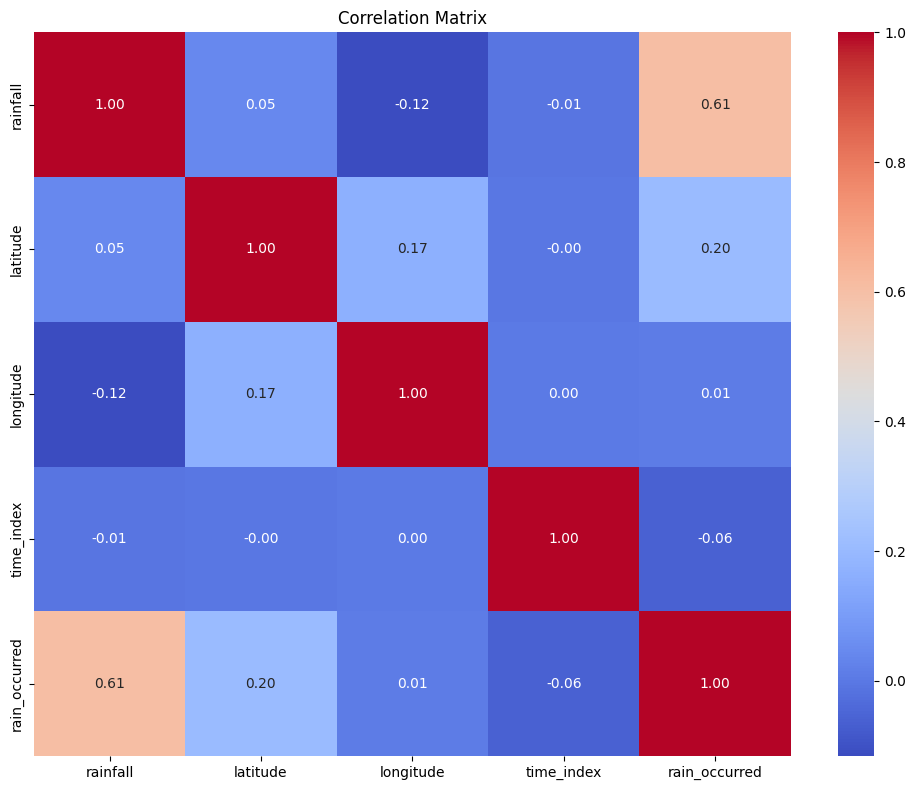

In [12]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')  # Save the figure
plt.show()

# Prepare Data for Machine Learning

In [13]:
# Prepare data for rainfall prediction (binary classification: rain or no rain)
X = data[['latitude', 'longitude', 'time_index']]
y = data['rain_occurred']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model

In [14]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make prediction
y_pred = model.predict(X_test)

# Evaluate Model

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.6218601493550577
              precision    recall  f1-score   support

           0       0.64      0.90      0.75       914
           1       0.51      0.16      0.24       559

    accuracy                           0.62      1473
   macro avg       0.57      0.53      0.50      1473
weighted avg       0.59      0.62      0.56      1473



# Visualize Results

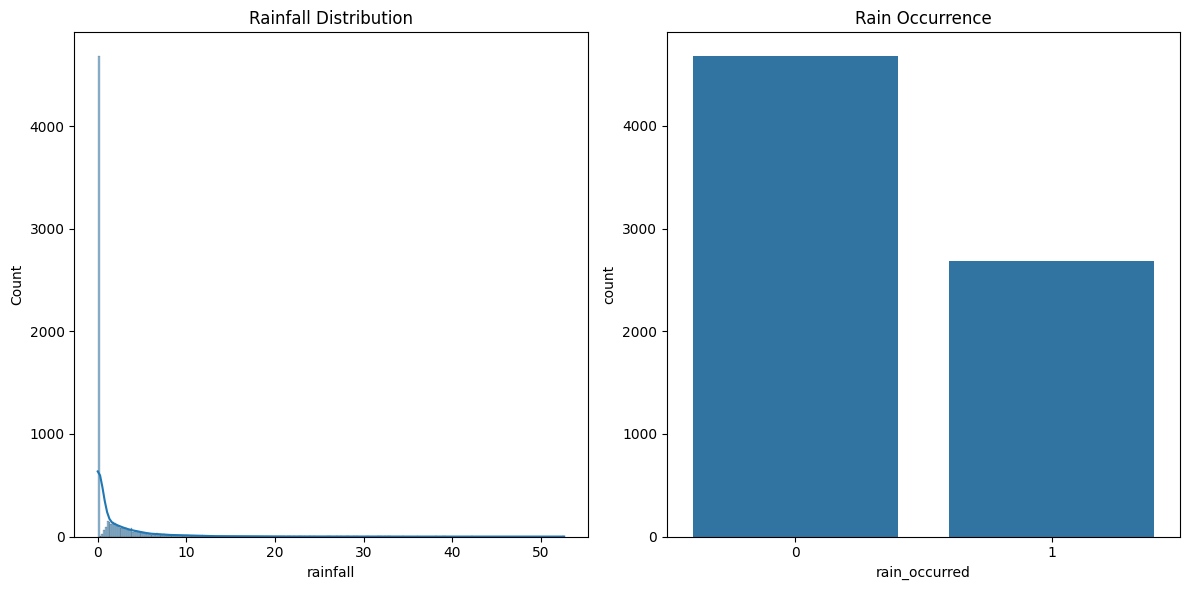

In [16]:
# Visualize rainfall distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['rainfall'], kde=True)
plt.title('Rainfall Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x='rain_occurred', data=data)
plt.title('Rain Occurrence')
plt.tight_layout()

plt.savefig('rainfall_distribution.png')
plt.show()